# Config file of an example using LSTM-KF-RL on a synthetic time series
This file include 
1. import data
2. training BDLM-LSTM model with hyper-parameters-free AR
3. check if the BDLM-LSTM model is correct (LSTM, AR, AA)
4. generate time series for RL agent training
5. train RL agents
6. evaluate the performance of RL agents

In [1]:
import os
os.chdir('/Users/zhanwenxin/Documents/GitHub/cuTAGI')

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
import csv
import pandas as pd
import copy
import scipy.io as sio

from tqdm import tqdm
from datetime import datetime
from src.RL_functions.generate_synthetic_time_series import *
from scipy.stats import norm

from src.RL_functions.generate_one_synthetic_time_series import generate_one_synthetic_time_series
from src.RL_functions.BDLM_trainer import BDLM_trainer
from src.RL_functions.regime_change_detection_tagiV import regime_change_detection_tagiV
from examples.data_loader import TimeSeriesDataloader, SyntheticTimeSeriesDataloader
from pytagi.hybrid import *
from pytagi.nn import LSTM, Linear, OutputUpdater, Sequential
from pytagi import Normalizer, Utils

## 1. Import data

In [2]:
# Import data
time_series_path = './data/synthetic/observation.csv'
# Load csv, no header
y_disp = pd.read_csv(time_series_path, header=None)[0].tolist()
timestamps = pd.date_range(start='1/1/2020', periods=len(y_disp), freq='W')
time_covariates = ['week_of_year']
obs_file_paths = ['data/synthetic/ytrain_obs.csv', 'data/synthetic/yval_obs.csv', 'data/synthetic/ytest_obs.csv']
date_file_paths=['data/synthetic/ytrain_datetime.csv', 'data/synthetic/yval_datetime.csv', 'data/synthetic/ytest_datetime.csv']

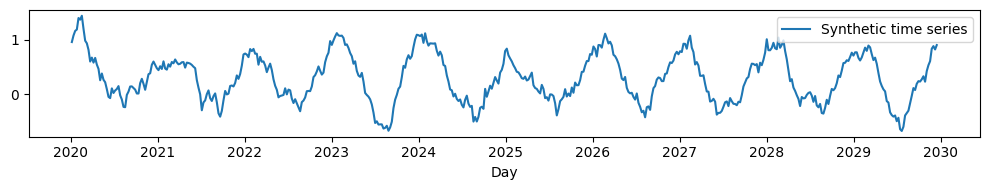

In [3]:
data_preprocessor = generate_one_synthetic_time_series(used_for_generation=False)
data_preprocessor.time_series['y'] = y_disp
data_preprocessor.time_series['timesteps'] = timestamps
data_preprocessor.time_step_interval = 7
data_preprocessor.export_to_csv(indices_train_val_test=[4*52, 5*52, -1],
                     observation_file_paths = obs_file_paths,
                     datetime_file_paths=date_file_paths,
                     start_datetime=datetime(2012, 1, 15, 12, 0, 0))
val_datetime_values = data_preprocessor.get_validation_datetime_values()
data_preprocessor.plot()

## 2. Train BDLM
The components are AA + AR + LSTM. The AR component here learns automatically the phi_AR and sigma_AR

### BDLM training configuration

In [4]:
num_epochs: int = 100
batch_size: int = 1
sigma_v: float = 1E-12

"""Run training for time-series forecasting model"""
# Dataset
output_col = [0]
num_features = 2
input_seq_len = 26
output_seq_len = 1
seq_stride = 1

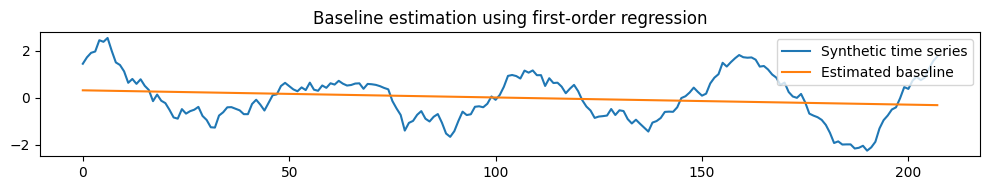

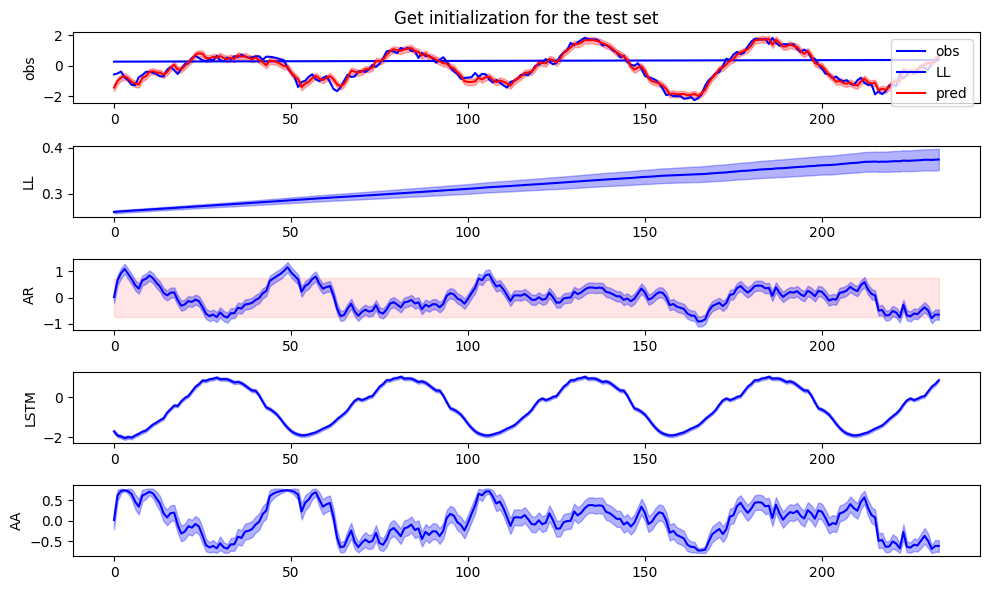

In [5]:
BDLM = BDLM_trainer(num_epochs=num_epochs,
                    batch_size=batch_size,
                    sigma_v=sigma_v,
                    output_col=output_col,
                    num_features=num_features,
                    components = 'LT + BAR + ITV + AR',
                    use_BAR = True,
                    input_BAR = [2, -2, 2],
                    input_seq_len=input_seq_len,
                    output_seq_len=output_seq_len,
                    seq_stride=seq_stride)
BDLM.load_datasets(obs_file_paths, date_file_paths, time_covariates)
BDLM.estimate_initial_baseline(plot=True)

# initial_z = np.array([0.26, 0.0005, 0, 0, 0.8, 0.02])
# initial_Sz = np.array([1E-5, 1E-8, 1e-20, 1e-20, 0.05**2, 0.15**2])
# BDLM.train(plot=True, early_stopping=True, patience=10, initial_z = initial_z, initial_Sz = initial_Sz)
# BDLM.save_LSTM_model(path = './saved_param/synthetic/lstm_test1.pth')
# # Store the smoothed initial value from training + validation sets, and remove the phi_AR hidden state
# print(BDLM.phi_AR)
# print(BDLM.Sigma_AR)
# print(BDLM.var_phi_AR)
# print(BDLM.var_Sigma_AR)

BDLM.phi_AR = 0.871505143847883
BDLM.Sigma_AR = 0.03275577237587235
BDLM.var_phi_AR = 0.0008671138875746663
BDLM.var_Sigma_AR = 2.6628888745464738e-05
BDLM.load_LSTM_model(path = './saved_param/synthetic/lstm_test1.pth')

initial_z = np.array([0.26, 0.0005, 0, 0, 0.02])
initial_Sz = np.array([1E-5, 1E-8, 1e-20, 1e-20, 0.15**2])

LSTM_net, init_mu_lstm, init_var_lstm, init_z, init_Sz, init_mu_W2b, init_var_W2b,\
last_seq_obs, last_seq_datetime, last_lstm_x = BDLM.get_testing_model_initials(val_datetime_values=val_datetime_values, plot=True,
                                                                               initial_z = initial_z, initial_Sz = initial_Sz)

In [6]:
print(initial_z, initial_Sz)

[0.26   0.0005 0.     0.     0.02  ] [1.00e-05 1.00e-08 1.00e-20 1.00e-20 2.25e-02]


## 3. Check if ITV is correct

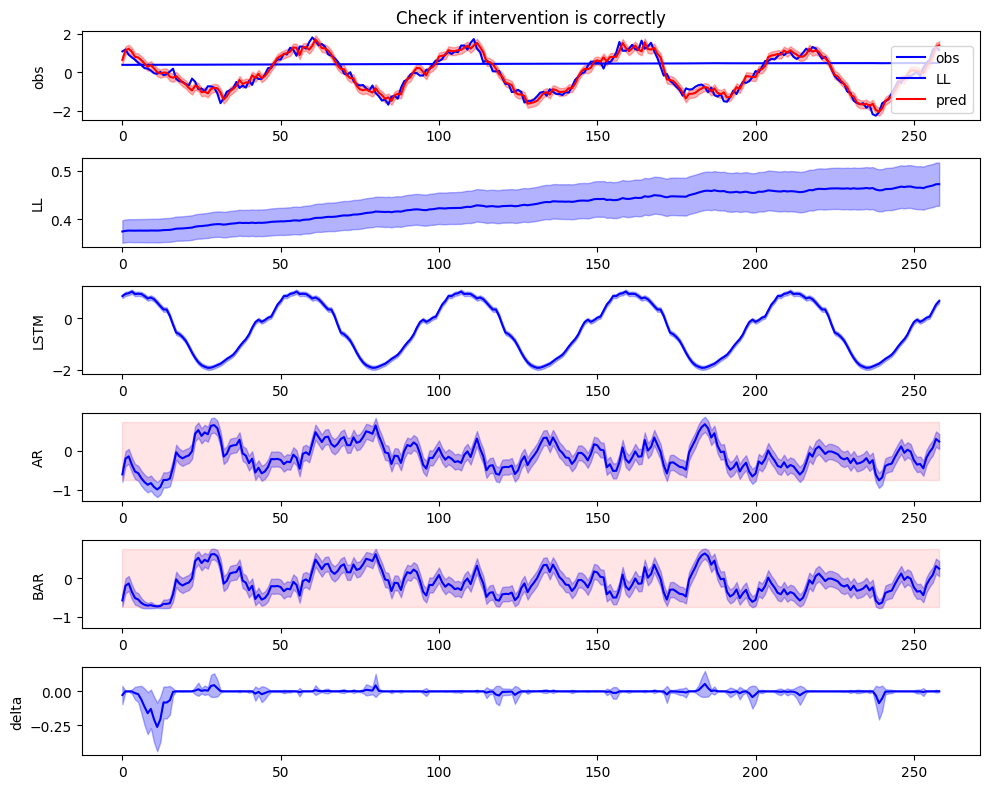

In [7]:
BDLM.check_AA(plot = True)

## 4. RL agent

In [8]:
# init_z = np.delete(init_z, 2, axis=0)
# init_z = np.delete(init_z, 2, axis=0)
# init_Sz = np.delete(init_Sz, 2, axis=0)
# init_Sz = np.delete(init_Sz, 2, axis=0)
# init_Sz = np.delete(init_Sz, 2, axis=1)
# init_Sz = np.delete(init_Sz, 2, axis=1)

In [9]:
# Training RL
# Initialize environment
from pytagi.LSTM_KF_RL_Env import LSTM_KF_Env
train_dtl = BDLM.train_dtl
env = LSTM_KF_Env(render_mode=None, data_loader=train_dtl, \
                    ts_model=BDLM.model, step_look_back=64)
state, _ = env.reset(z=init_z, Sz=init_Sz, mu_preds_lstm = copy.deepcopy(init_mu_lstm), var_preds_lstm = copy.deepcopy(init_var_lstm),\
                    net_test=LSTM_net, init_mu_W2b=init_mu_W2b, init_var_W2b=init_var_W2b, phi_AR=BDLM.phi_AR, Sigma_AR=BDLM.Sigma_AR,
                    phi_AA = BDLM.phi_AA, Sigma_AA_ratio = BDLM.Sigma_AA_ratio, use_BAR = BDLM.use_BAR, input_BAR = BDLM.input_BAR)
n_actions = env.action_space.n
n_observations = len(state['hidden_states'])
agents_RL = regime_change_detection_tagiV(trained_BDLM = BDLM, val_datetime_values = val_datetime_values,
                                         n_observations = n_observations, n_actions = n_actions)
agent_model_path = './saved_param/synthetic/lstm_test1.pth'

# # Generate synthetic time series
# paths = ['./saved_param/synthetic/lstm_test1.pth']
# agents_RL.generate_synthetic_ts(num_syn_ts = 1000, syn_ts_len = 52 * 6, paths_all=paths)
# agents_RL.save_synthetic_ts(datetime_save_path='data/synthetic/RLDS_y_datetime_1000episodes_nomixed_V1.csv',
#                              observation_save_path='data/synthetic/RLDS_y_observation_1000episodes_nomixed_V1.csv')

[116.   2.   4.   4.   4.   5.   3.   3.   4.   4.   6.   4.   6.  10.
   4.   3.   3.   3.   2.   3.   3.   3.   3.   3.   2.   4.   5.   3.
   3.   6.   2.   4.   1.   3.   2.   3.   4.   1.   4.   2.   2.   2.
   1.   3.   2.   3.   2.   1.   1.   2.   4.   2.   2.   3.   2.   3.
   2.   1.   2.   1.   1.   2.   2.   2.   1.   2.   2.   2.   1.   2.
   2.   3.   2.   1.   2.   2.   1.   2.   1.   2.   2.   2.   2.   2.
   2.   2.   2.   1.   2.   1.   2.   1.   1.   2.   2.   2.   2.   2.
   1.   2.   2.   1.   2.   2.   2.   1.   1.   1.   1.   1.   1.   2.
   1.   2.   1.   2.   1.   2.   2.   2.   2.   1.   2.   1.   1.   2.
   2.   2.   2.   1.   1.   1.   1.   1.   2.   2.   2.   2.   1.   2.
   2.   2.   2.   2.   2.   2.   1.   2.   1.   2.   2.   1.   1.   1.
   2.   2.   2.   2.   2.   2.   2.   1.   2.   2.   1.   2.   1.   2.
   2.   1.   2.   2.   2.   2.   1.   2.   2.   2.   2.   2.   2.   2.
   2.   1.   1.   2.   2.   2.   2.   2.   2.   1.   2.   2.   2.   2.
   2. 

<Figure size 640x480 with 0 Axes>

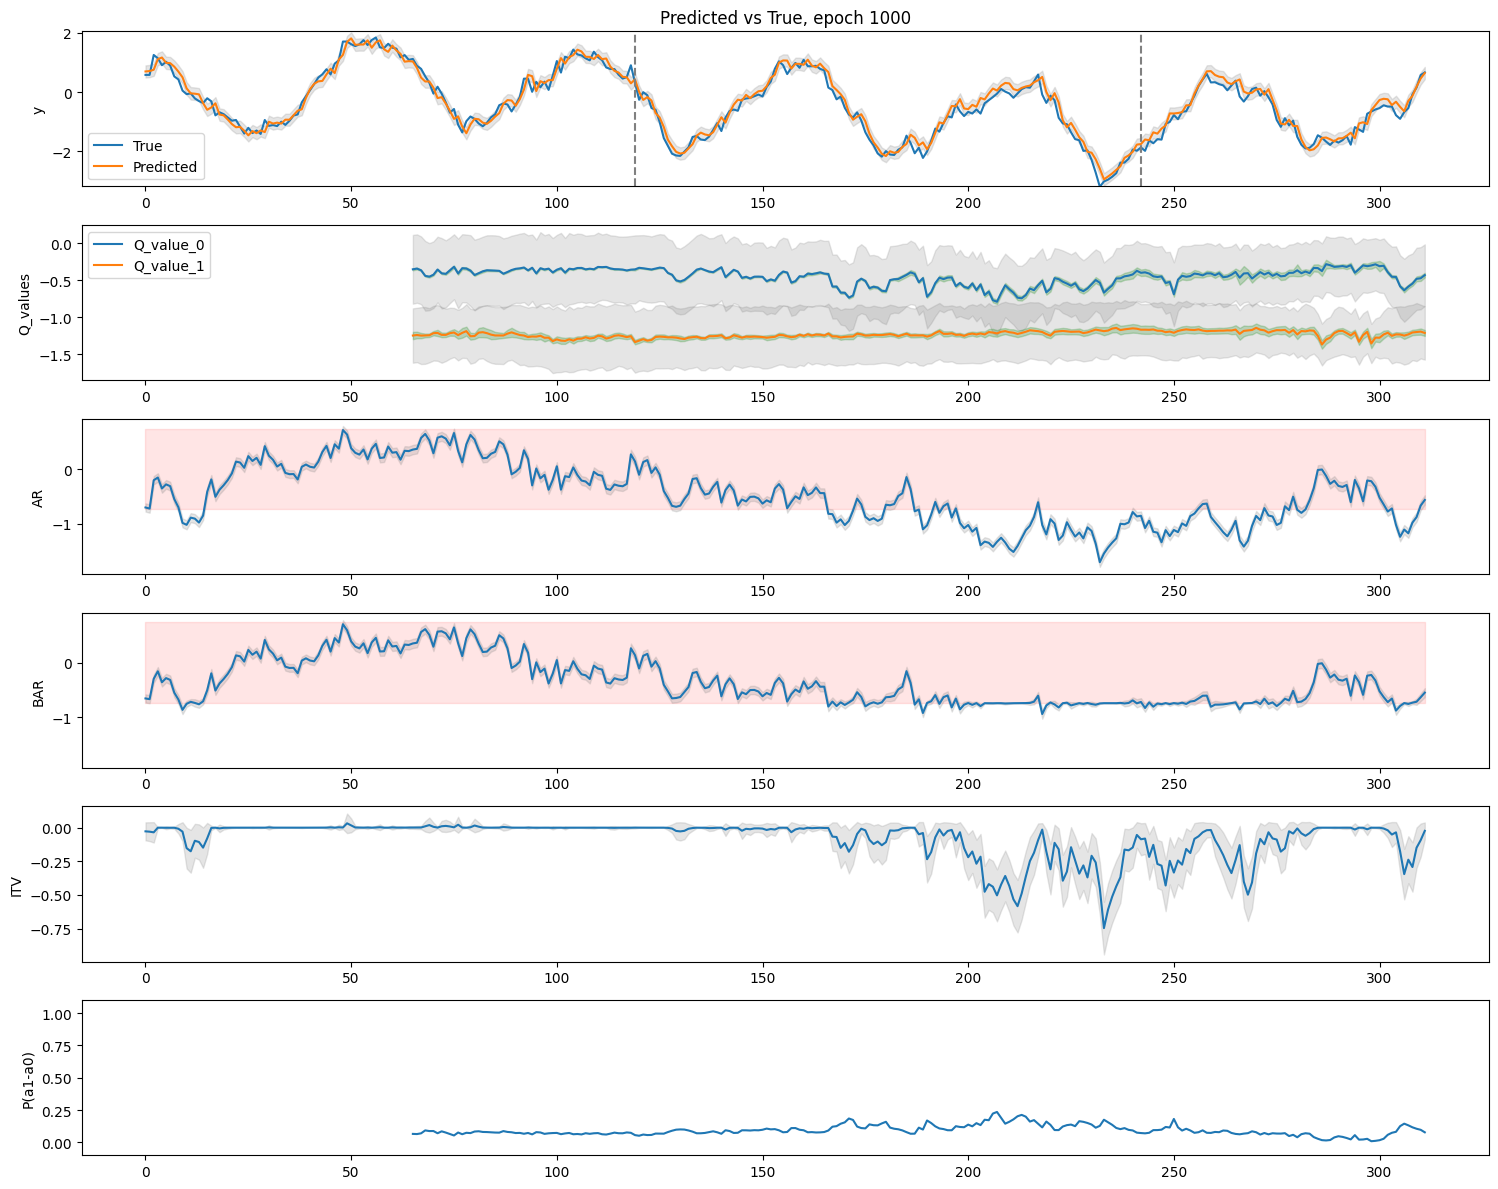

Complete


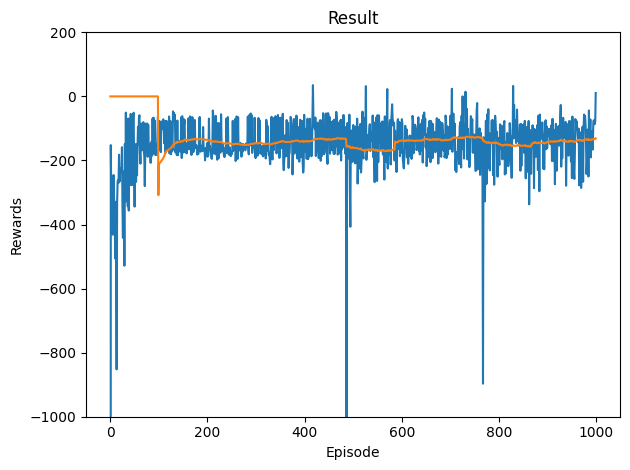

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

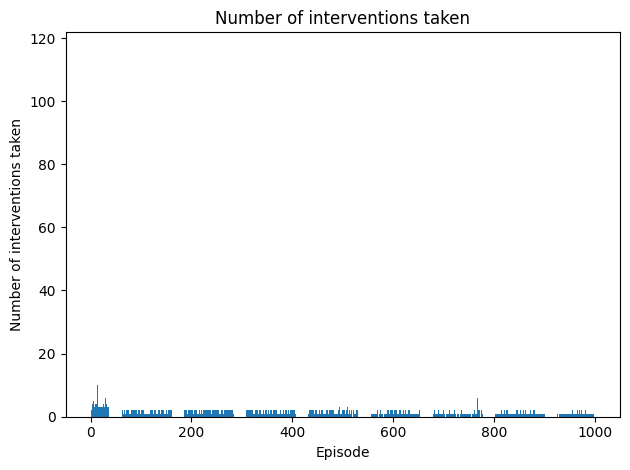

In [10]:
agents_RL.load_synthetic_ts(datetime_save_path='data/synthetic/RLDS_y_datetime_1000episodes_nomixed_V1.csv',
                            observation_save_path='data/synthetic/RLDS_y_observation_1000episodes_nomixed_V1.csv')
agents_RL.plot_synthetic_ts()

# Training: TAGI
agents_RL.train(num_episodes = 1000, step_look_back = 64, abnormal_ts_percentage = 1, anomaly_range = [-0.05, 0.05],
                init_z = init_z, init_Sz = init_Sz, init_mu_preds_lstm = init_mu_lstm, init_var_preds_lstm = init_var_lstm,
                batchsize = 128, TAU = 0.005, plot_samples = True, learning_curve_ylim = [-1000, 200],
                early_stopping = False, patience = 0, validation_episode_num = 0, early_stop_start= 300,
                # agent_net_save_path = agent_model_path)
                agent_net_save_path = agent_model_path, mean_R = 0.157579007610389, std_R = 0.6997088860885404)
                # agent_net_save_path = agent_model_path, mean_R = -7.2246003836239625, std_R = 12.316401438660733)

In [11]:
print(val_datetime_values)

['2015-07-12 12:00:00', '2015-07-19 12:00:00', '2015-07-26 12:00:00', '2015-08-02 12:00:00', '2015-08-09 12:00:00', '2015-08-16 12:00:00', '2015-08-23 12:00:00', '2015-08-30 12:00:00', '2015-09-06 12:00:00', '2015-09-13 12:00:00', '2015-09-20 12:00:00', '2015-09-27 12:00:00', '2015-10-04 12:00:00', '2015-10-11 12:00:00', '2015-10-18 12:00:00', '2015-10-25 12:00:00', '2015-11-01 12:00:00', '2015-11-08 12:00:00', '2015-11-15 12:00:00', '2015-11-22 12:00:00', '2015-11-29 12:00:00', '2015-12-06 12:00:00', '2015-12-13 12:00:00', '2015-12-20 12:00:00', '2015-12-27 12:00:00', '2016-01-03 12:00:00', '2016-01-10 12:00:00', '2016-01-17 12:00:00', '2016-01-24 12:00:00', '2016-01-31 12:00:00', '2016-02-07 12:00:00', '2016-02-14 12:00:00', '2016-02-21 12:00:00', '2016-02-28 12:00:00', '2016-03-06 12:00:00', '2016-03-13 12:00:00', '2016-03-20 12:00:00', '2016-03-27 12:00:00', '2016-04-03 12:00:00', '2016-04-10 12:00:00', '2016-04-17 12:00:00', '2016-04-24 12:00:00', '2016-05-01 12:00:00', '2016-05-0